In [1]:
import numpy as np
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
import tensorflow as tf
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import plot_model
from PIL import Image

warnings.filterwarnings("ignore")

In [2]:
base_directory = '/Users/sertaccem/PycharmProjects/BSBI/CV and AI/chest_xray'
train_directory = '/Users/sertaccem/PycharmProjects/BSBI/CV and AI/chest_xray/train'
val_directory = '/Users/sertaccem/PycharmProjects/BSBI/CV and AI/chest_xray/val'
test_directory = '/Users/sertaccem/PycharmProjects/BSBI/CV and AI/chest_xray/test'

In [3]:
folders = ['train', 'val', 'test']

image_counts = {}

for folder in folders:
    split_dir = os.path.join(base_directory, folder)
    
    image_counts[folder] = {}
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(split_dir, class_name)
        
        num_of_images = len(os.listdir(class_path))
        
        image_counts[folder][class_name] = num_of_images

data = []

for split, classes in image_counts.items():
    for class_name, count in classes.items():
        print(f"Dataset: {split}, Class: {class_name}, Number of images: {count}")
        data.append({'Dataset': split, 'Class': class_name, 'Number of Images': count})

df = pd.DataFrame(data)

Dataset: train, Class: NORMAL, Number of images: 1343
Dataset: train, Class: PNEUMONIA, Number of images: 3875
Dataset: val, Class: NORMAL, Number of images: 8
Dataset: val, Class: PNEUMONIA, Number of images: 8
Dataset: test, Class: NORMAL, Number of images: 234
Dataset: test, Class: PNEUMONIA, Number of images: 390


In [5]:
df

,Dataset,Class,Number of Images
0,train,NORMAL,1343
1,train,PNEUMONIA,3875
2,val,NORMAL,8
3,val,PNEUMONIA,8
4,test,NORMAL,234
5,test,PNEUMONIA,390


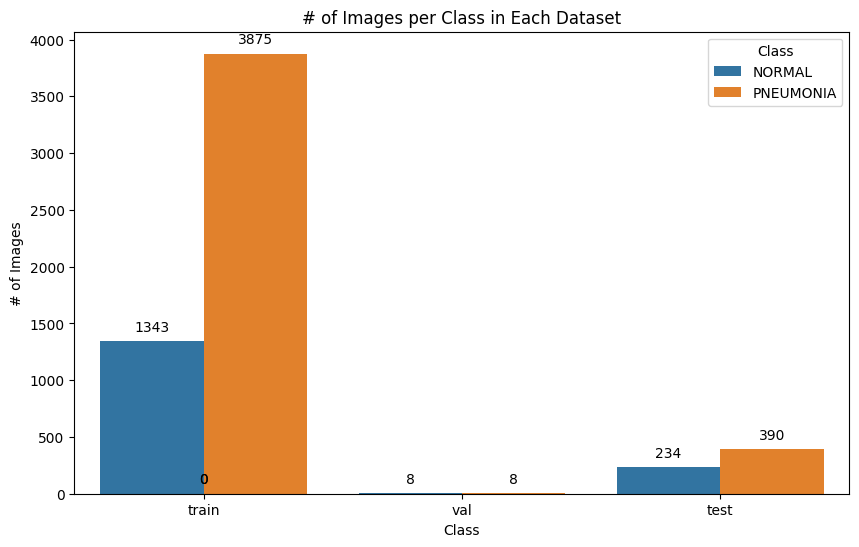

In [6]:
import seaborn as sns

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Dataset', y='Number of Images', hue='Class', data=df)

for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), '.0f'),  
        (p.get_x() + p.get_width() / 2., p.get_height()),  
        ha = 'center',  
        va = 'center',  
        xytext=(0, 10), 
        textcoords='offset points'  
    )

plt.title('# of Images per Class in Each Dataset')
plt.xlabel('Class')
plt.ylabel('# of Images')

plt.show()

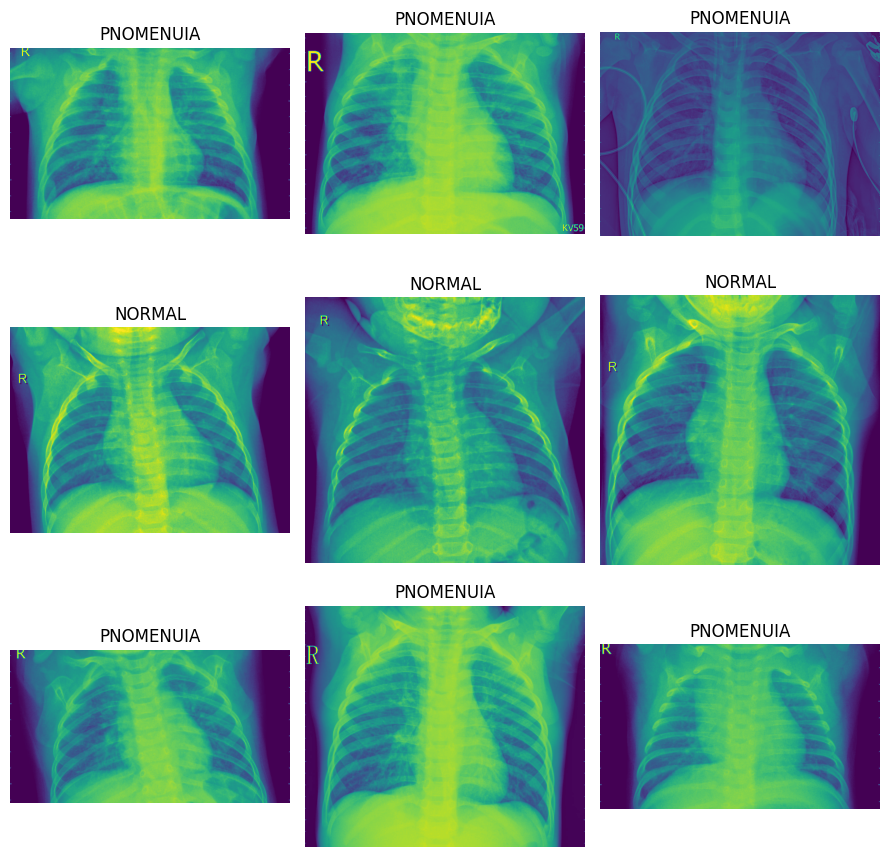

In [7]:
pneumonia_folder = os.path.join(train_directory, "PNEUMONIA")
normal_folder = os.path.join(train_directory, "NORMAL")

pneumonia_images = [os.path.join(pneumonia_folder, img) for img in os.listdir(pneumonia_folder)]
normal_images = [os.path.join(normal_folder, img) for img in os.listdir(normal_folder)]

random_pneumonia = random.sample(pneumonia_images, 6) 
random_normal = random.sample(normal_images, 3)  

fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, img_path in enumerate(random_pneumonia[:3]):
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('PNOMENUIA')

for i, img_path in enumerate(random_normal):
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('NORMAL')

for i, img_path in enumerate(random_pneumonia[3:]):
    img = Image.open(img_path)
    axes[2, i].imshow(img)
    axes[2, i].axis('off')
    axes[2, i].set_title('PNOMENUIA')

plt.tight_layout()
plt.show()

In [12]:
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.4,2.0],
        width_shift_range = 0.2,
        rotation_range=15,
        fill_mode = 'nearest'
)

val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [13]:
train = Image_gen.flow_from_directory(train_directory,
                                       batch_size=32,
                                       class_mode='binary',
                                       target_size=(224, 224)
                                       )

validation = Image_gen.flow_from_directory(val_directory,
                                              batch_size=32,
                                              class_mode='binary',
                                              target_size=(224, 224)
                                            )

test = val_Datagen.flow_from_directory(test_directory,
                                       batch_size=32,
                                       class_mode='binary',
                                       target_size=(224, 224)
                                      )

Found 5217 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
img, label = next(train)

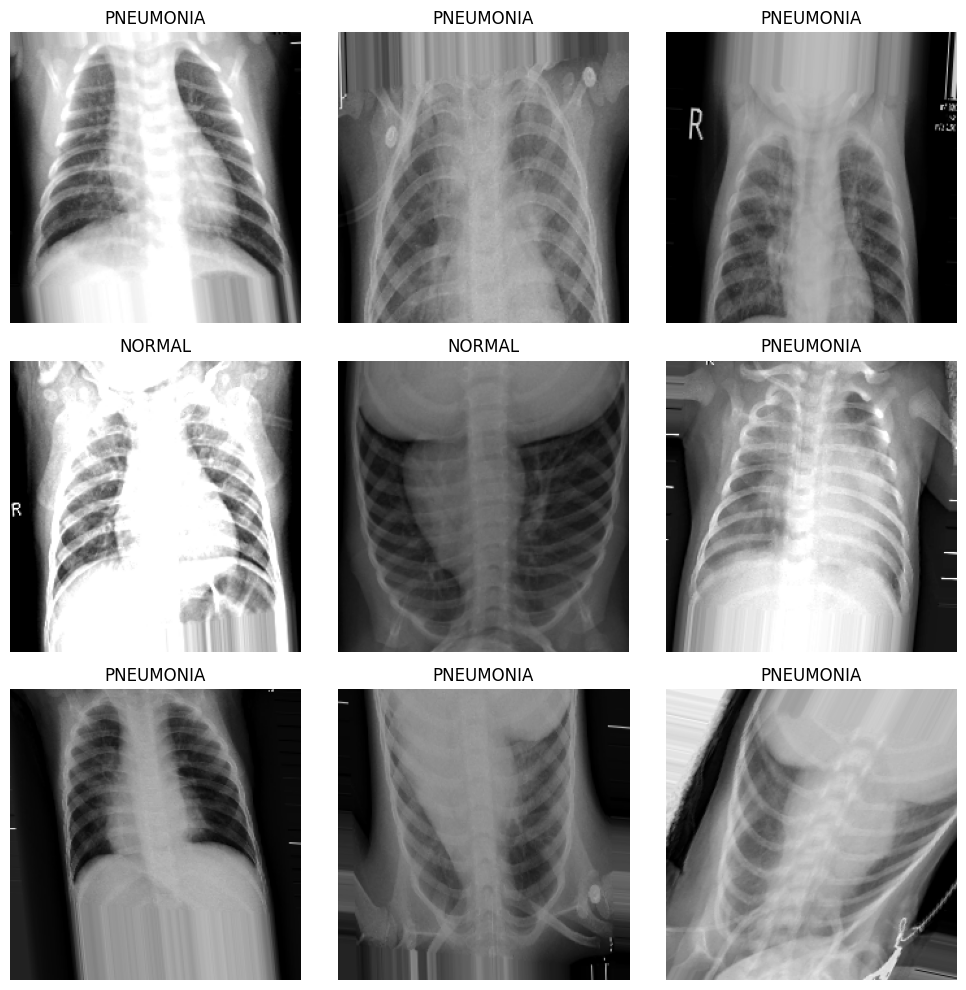

In [15]:
# Here we can see the augmented/generated images

class_names = list(train.class_indices.keys())

plt.figure(figsize=(10, 10))

for i in range(9):  
    plt.subplot(3, 3, i+1)
    plt.imshow(img[i])  
    plt.title(class_names[int(label[i])])
    plt.axis('off')  

plt.tight_layout()
plt.show()

In [16]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False

x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# Compiling the model
res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy', 
                                                                        tf.keras.metrics.Precision(), 
                                                                        tf.keras.metrics.Recall()])

2024-09-26 01:19:18.886314: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-26 01:19:18.886348: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-26 01:19:18.886364: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-26 01:19:18.886422: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-26 01:19:18.886444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
res_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [18]:
history = res_model.fit(train,
                        epochs=30, 
                        validation_data=validation,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=15),tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)],
                        batch_size=32)

Epoch 1/30


2024-09-26 01:20:33.342875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/sertaccem/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 307ms/step - accuracy: 0.8728 - loss: 0.2900 - precision: 0.9012 - recall: 0.9303 - val_accuracy: 0.9375 - val_loss: 0.4021 - val_precision: 0.8889 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - accuracy: 0.9303 - loss: 0.1716 - precision: 0.9489 - recall: 0.9566 - val_accuracy: 0.8125 - val_loss: 0.6812 - val_precision: 0.7273 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 50s 291ms/step - accuracy: 0.9041 - loss: 0.2412 - precision: 0.9323 - recall: 0.9387 - val_accuracy: 0.5625 - val_loss: 1.6003 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 296ms/step - accuracy: 0.9336 - loss: 0.1712 - precision: 0.9506 - recall: 0.9604 - val_accuracy: 0.8125 - val_loss: 0.6416 - val_precision: 0.7273 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - accura

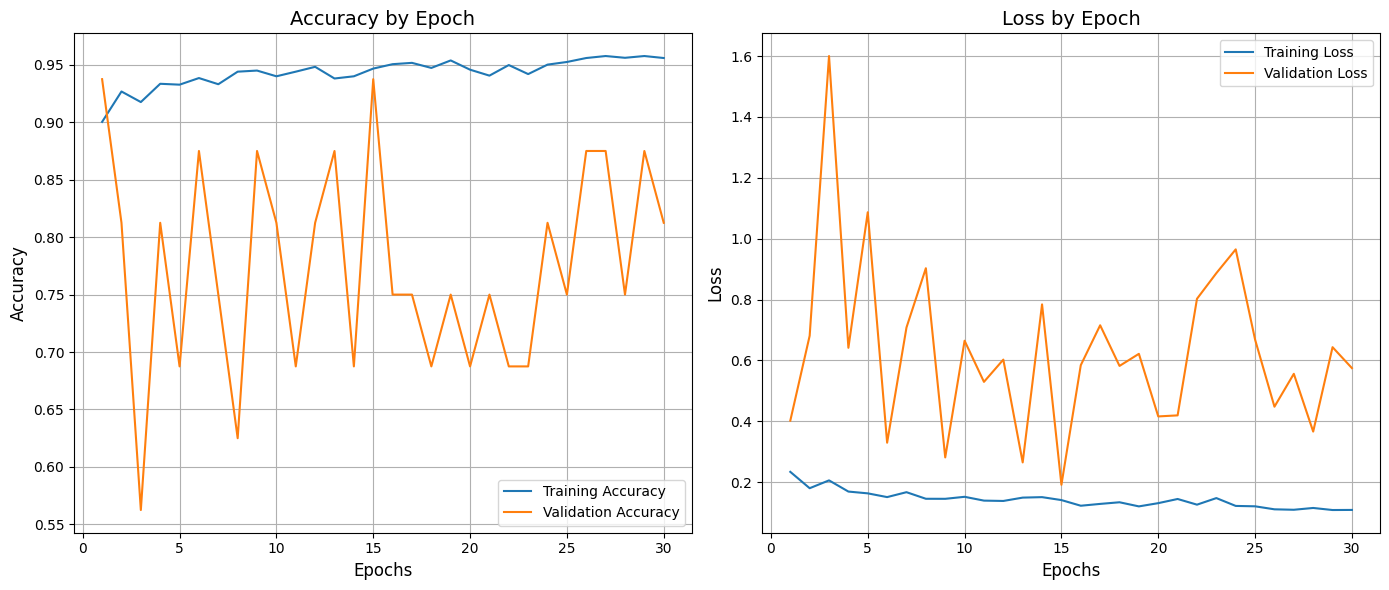

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)  

# This one will generate subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# This is for accuracy
ax1.plot(epochs, train_acc, label='Training Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy by Epoch', fontsize=14)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True)

# This one is for the loss graph
ax2.plot(epochs, train_loss, label='Training Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_title('Loss by Epoch', fontsize=14)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True) 

plt.tight_layout()

plt.show()

In [ ]:
# Let's evaluate our model
score = res_model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])
print("Test Precision: ", score[2])
print("Test Recall: ", score[3])

score = res_model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])
print("Test Precision: ", score[2])
print("Test Recall: ", score[3])

164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 290ms/step - accuracy: 0.9558 - loss: 0.1163 - precision: 0.9713 - recall: 0.9697
Train Loss:  0.11799845844507217
Train Accuracy:  0.9547632932662964
Test Precision:  0.968339741230011
Test Recall:  0.970838725566864
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.9313 - loss: 0.2252 - precision: 0.9269 - recall: 0.9643

Test loss:  0.2419746071100235
Test Accuracy:  0.9262820482254028
Test Precision:  0.9215686321258545
Test Recall:  0.964102566242218
